In [9]:
! pip install opencv-python matplotlib numpy
import cv2
import numpy as np
import matplotlib.pyplot as plt

Defaulting to user installation because normal site-packages is not writeable


In [10]:
def gaussian_filter(size, sigma):
    filter = np.zeros((size, size))
    center = size // 2
    sum = 0
    for i in range(size):
        for j in range(size):
            filter[i,j] = np.exp(-((i-center)**2 + (j-center)**2)/(2*sigma**2))
            sum += filter[i,j]
    filter /= sum
    return filter

In [28]:
def convolve(image, kernel):
    m, _ = kernel.shape
    y, x = image.shape
    y = y - m + 1
    x = x - m + 1
    filtered_image = np.zeros((y,x))
    for i in range(y):
        for j in range(x):
            filtered_image[i][j] = np.sum(image[i:i+m, j:j+m]*kernel)
    return filtered_image

In [29]:
def apply_gaussian_filter(image, size, sigma):
    kernel = gaussian_filter(size, sigma)
    return convolve(image, kernel)


In [30]:
def calculate_gradient(image):
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]])

    sobel_y = np.array([[-1, -2, -1],
                        [0, 0, 0],
                        [1, 2, 1]])

    grad_x = convolve(image, sobel_x)
    grad_y = convolve(image, sobel_y)

    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    direction = np.arctan2(grad_y, grad_x)

    return magnitude, direction


In [31]:
def non_max_suppression(gradient_magnitude, gradient_direction):
    angle_quantization = np.round(gradient_direction / (np.pi/4)) % 4
    M, N = gradient_magnitude.shape
    non_max_suppressed = np.zeros((M,N), dtype=np.int32)

    for i in range(1, M-1):
        for j in range(1, N-1):
            direction = angle_quantization[i, j]
            if direction == 0:
                before_pixel = gradient_magnitude[i, j-1]
                after_pixel = gradient_magnitude[i, j+1]
            elif direction == 1:
                before_pixel = gradient_magnitude[i-1, j+1]
                after_pixel = gradient_magnitude[i+1, j-1]
            elif direction == 2:
                before_pixel = gradient_magnitude[i-1, j]
                after_pixel = gradient_magnitude[i+1, j]
            elif direction == 3:
                before_pixel = gradient_magnitude[i-1, j-1]
                after_pixel = gradient_magnitude[i+1, j+1]

            if gradient_magnitude[i,j] >= before_pixel and gradient_magnitude[i,j] >= after_pixel:
                non_max_suppressed[i,j] = gradient_magnitude[i,j]

    return non_max_suppressed


In [32]:
def double_thresholding(image, low_threshold_ratio=0.05, high_threshold_ratio=0.09):
    low_threshold = np.max(image) * low_threshold_ratio
    high_threshold = np.max(image) * high_threshold_ratio
    M, N = image.shape

    edges = np.zeros((M,N), dtype=np.int32)
    strong_edges_i, strong_edges_j = np.where(image >= high_threshold)
    edges[strong_edges_i, strong_edges_j] = 255

    weak_edges_i, weak_edges_j = np.where((image >= low_threshold) & (image < high_threshold))
    edges[weak_edges_i, weak_edges_j] = 50

    for i in range(1, M-1):
        for j in range(1, N-1):
            if edges[i,j] == 50:
                if np.max(edges[i-1:i+2, j-1:j+2]) == 255:
                    edges[i,j] = 255
                else:
                    edges[i,j] = 0

    weak_edges_i, weak_edges_j = np.where(edges == 50)
    edges[weak_edges_i, weak_edges_j] = 0

    return edges


In [48]:
def apply_canny_edge_detection(image, low_threshold, high_threshold):
    filtered_image = apply_gaussian_filter(image, size=5, sigma=1.4)
    gradient_magnitude, gradient_direction = calculate_gradient(filtered_image)
    suppressed_image = non_max_suppression(gradient_magnitude, gradient_direction)
    edges = double_thresholding(suppressed_image, low_threshold, high_threshold)

    _, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
    ax1.imshow(image, cmap='gray')
    ax1.set_title('Imagem Original')
    ax1.axis('off')
    ax2.imshow(edges, cmap='gray')
    ax2.set_title('Bordas de Canny')
    ax2.axis('off')
    plt.savefig('canny.png', bbox_inches='tight')
    plt.show()

    return edges

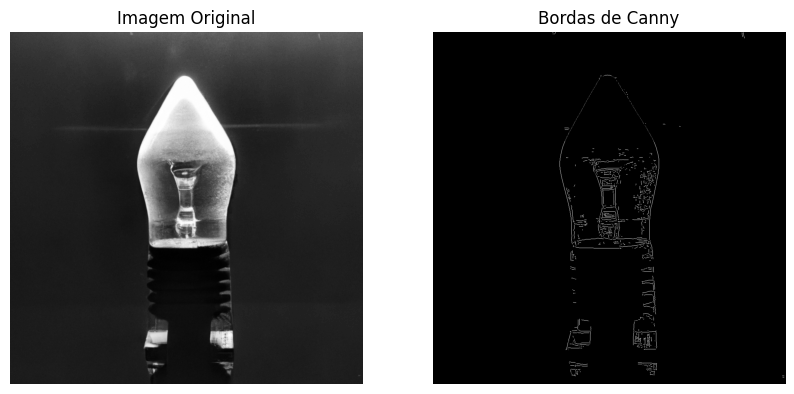

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [54]:
apply_canny_edge_detection(cv2.imread('grayscale_1.png', cv2.IMREAD_GRAYSCALE), 0.09, 0.13)

In [56]:
def sobel_detector(image):
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1],
                        [0, 0, 0],
                        [1, 2, 1]])

    gradient_x = convolve(image, sobel_x)
    gradient_y = convolve(image, sobel_y)

    gradient_magnitude = np.sqrt(np.square(gradient_x) + np.square(gradient_y))
    gradient_magnitude *= 255.0 / np.max(gradient_magnitude)

    gradient_image = gradient_magnitude.astype(np.uint8)

    _, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
    ax1.imshow(image, cmap='gray')
    ax1.set_title('Imagem Original')
    ax1.axis('off')
    ax2.imshow(gradient_image, cmap='gray')
    ax2.set_title('Bordas de Sobel')
    ax2.axis('off')
    plt.savefig('sobel.png', bbox_inches='tight')
    plt.show()

    return gradient_image


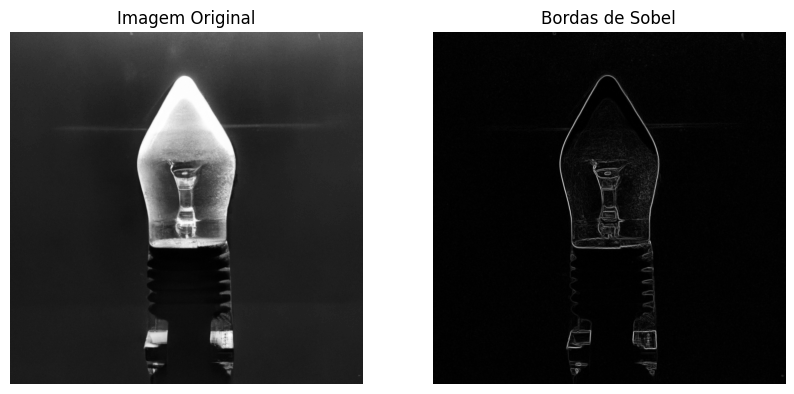

array([[47, 45, 47, ..., 29, 30, 32],
       [ 6,  7,  6, ...,  3,  3,  4],
       [ 3,  1,  1, ...,  5,  4,  2],
       ...,
       [ 3,  2,  4, ...,  4,  5,  2],
       [ 0,  3,  3, ...,  0,  5,  2],
       [ 3,  3,  2, ...,  2,  4,  4]], dtype=uint8)

In [59]:
sobel_detector(cv2.imread('grayscale_1.png', cv2.IMREAD_GRAYSCALE))

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def frei_chen_detector(image):
    masks = [np.array([[1, np.sqrt(2), 1],
                       [0, 0, 0],
                       [-1, -np.sqrt(2), -1]]),
             np.array([[-1, 0, 1],
                       [-np.sqrt(2), 0, np.sqrt(2)],
                       [-1, 0, 1]]),
             np.array([[-1, -np.sqrt(2), -1],
                       [0, 0, 0],
                       [1, np.sqrt(2), 1]]),
             np.array([[1, 0, -1],
                       [np.sqrt(2), 0, -np.sqrt(2)],
                       [1, 0, -1]]),
             np.array([[0, 1, np.sqrt(2)],
                       [-1, 0, 1],
                       [-np.sqrt(2), -1, 0]]),
             np.array([[-np.sqrt(2), -1, 0],
                       [1, 0, -1],
                       [0, 1, np.sqrt(2)]]),
             np.array([[0, -1, -np.sqrt(2)],
                       [1, 0, -1],
                       [np.sqrt(2), 1, 0]]),
             np.array([[np.sqrt(2), 1, 0],
                       [-1, 0, -1],
                       [0, -1, -np.sqrt(2)]])
            ]
    gradient_magnitudes = []

    for mask in masks:
        gradient_magnitude = np.abs(convolve(image, mask))
        gradient_magnitudes.append(gradient_magnitude)

    min_gradient_magnitudes = np.min(gradient_magnitudes, axis=0)
    normalized_gradients = min_gradient_magnitudes / np.max(min_gradient_magnitudes)

    _, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
    ax1.imshow(image, cmap='gray')
    ax1.set_title('Imagem Original')
    ax1.axis('off')
    ax2.imshow(normalized_gradients, cmap='gray')
    ax2.set_title('Bordas de Frei-Chen')
    ax2.axis('off')
    plt.savefig('frei_chen.png', bbox_inches='tight')
    plt.show()

    return normalized_gradients


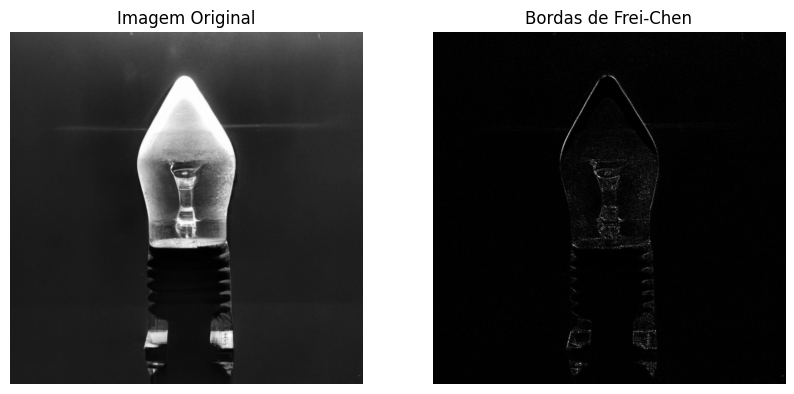

array([[4.27091005e-02, 9.47396360e-03, 4.27091005e-02, ...,
        3.66386159e-02, 5.73645468e-02, 2.41294099e-02],
       [4.48553409e-02, 1.55444482e-02, 2.19831695e-02, ...,
        7.32772317e-03, 5.18148274e-03, 1.76906887e-02],
       [2.14624043e-03, 7.36332985e-17, 5.18148274e-03, ...,
        1.98369291e-02, 3.03524232e-03, 1.25092059e-02],
       ...,
       [8.89001893e-04, 7.32772317e-03, 5.18148274e-03, ...,
        3.10888965e-02, 3.62703792e-02, 3.03524232e-03],
       [0.00000000e+00, 5.18148274e-03, 2.14624043e-03, ...,
        0.00000000e+00, 9.10572696e-03, 8.21672506e-03],
       [1.16202040e-02, 3.03524232e-03, 2.14624043e-03, ...,
        1.98369291e-02, 1.16202040e-02, 5.18148274e-03]])

In [60]:
frei_chen_detector(cv2.imread('grayscale_1.png', cv2.IMREAD_GRAYSCALE))